# Marketing

### Ad Click

Ad clicks are a huge source of revenue for many Internet marketing businesses. It is important to predict whether a user will click on an ad. When monitoring users of a website, just because a user does not click on an ad during the observation period, does not mean they won't at some future unobserved time. PU learning means learning from positive and unlabeled data. The unlabeled data contains both positive examples which are not observed (people who click on an ad after the trial is finished), as well as negative examples who truly never click on an ad, which we refer to as "cured".

The scenario of predicting whether a user will click on an ad can be modeled as a PU learning problem, with the following characteristics:

 - <b>Event of interest</b>: The user clicks on an ad
 
 - <b>Positive Data</b>: The users who clicked on an ad
 
 - <b>Unlabeled Data</b>: The users who did not click on the ad during the observation period 
 
 - <b>Cured population</b>: The users who will never click on the ad
 

In [18]:
import warnings
warnings.filterwarnings("ignore")

## Imports 

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.preprocessing import OneHotEncoder
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_advertising
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## The Advertising Dataset
For illustration we use the following [data set](https://www.kaggle.com/farhanmd29/predicting-customer-ad-clicks/data) from Kaggle.com.

In [21]:
# loading the data
dataset = dataset = load_advertising()
data, labels, times = dataset.data, dataset.target, dataset.target_times
dataset["data"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 70.4+ KB


The dataset contains 9 columns and 1000 rows. Some of the columns are numeric (Age, Area Income etc) while others contain string data. 
Lets view a few top rows of the data to see what it looks like.

In [22]:
# View the head of the data to see what it looks like
dataset["data"].head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18


## Using the SurvivalAnalysis Class
The apd_crs module expects censored data to be marked using _censor_label_ and cured data to be marked using _cure_label_. These can be obtained with the get_censor_label and get_cure_label methods as follows

In [23]:
# Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
non_cure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()

The load_advertising() method returns a dataset where the labels have been suitably preprocessed already. However, make sure to suitably convert the labels when applying SurvivalAnalysis on your datasets!

In [24]:
# In telco dataset, label of 2 implies censored, and 1 implies non_cured
labels = labels.replace({2: censor_label, 1: non_cure_label})

## Data Preprocessing


We drop cities and Ad Topic Line, since there are too many distinct ones for only 1000 samples.

In [25]:
data.drop(columns=['City', 'Ad Topic Line'], inplace=True)

We extract from Month, Day, Week, and Hour from the time stamp column, then drop it.

In [26]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Month'] = data['Timestamp'].dt.month
data['Day of month'] = data['Timestamp'].dt.day
data['Day of week'] = data['Timestamp'].dt.dayofweek
data['Hour'] = data['Timestamp'].dt.hour  
data.drop(columns=['Timestamp'], inplace=True)

## One-hot encoding

Our data includes the column "Country" which contains many different countries. We obviously need to convert these categorical values into numerical values before we can use them for our model. This is achieved through one-hot encoding. 

In [27]:
categorical_columns = ['Country']
encoded_data = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns)

## Train test split

We split the data into training and test sets. The model is fit on training data and evaluated on test data

In [28]:
# Test train split: To evaluate test performance we split the data into training and testing data;
# test_size is percentage going to test data
test_size = 0.33
(training_data, test_data, 
 training_labels, test_labels) = train_test_split(encoded_data, labels, 
                                                  test_size=test_size)

## Scaling
To ensure that a certain feature does not dominate other features due to its numerical range, we scale all features so they lie within the same range

In [29]:
# Scale covariates:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data)

## Using the SurvivalAnalysis Class: Model Fitting

In [30]:
# is_scar=True means we use the selected completely at rando
#Since our data has many columns relative to the number of rows, we use a high regularization penalty
model.pu_fit(training_data, training_labels, pu_reg_term=10., is_scar=True)

Before evaluating results, make sure to apply the same scaling that was applied to training data

In [31]:
scaled_test_data = scaler.transform(test_data)

## Overall Covariate Importance
We can use the get_covariate_importance method to retrieve the covariate importances. Let us retrieve the top 10 factors in absolute value to get an idea of what they are.

<AxesSubplot:>

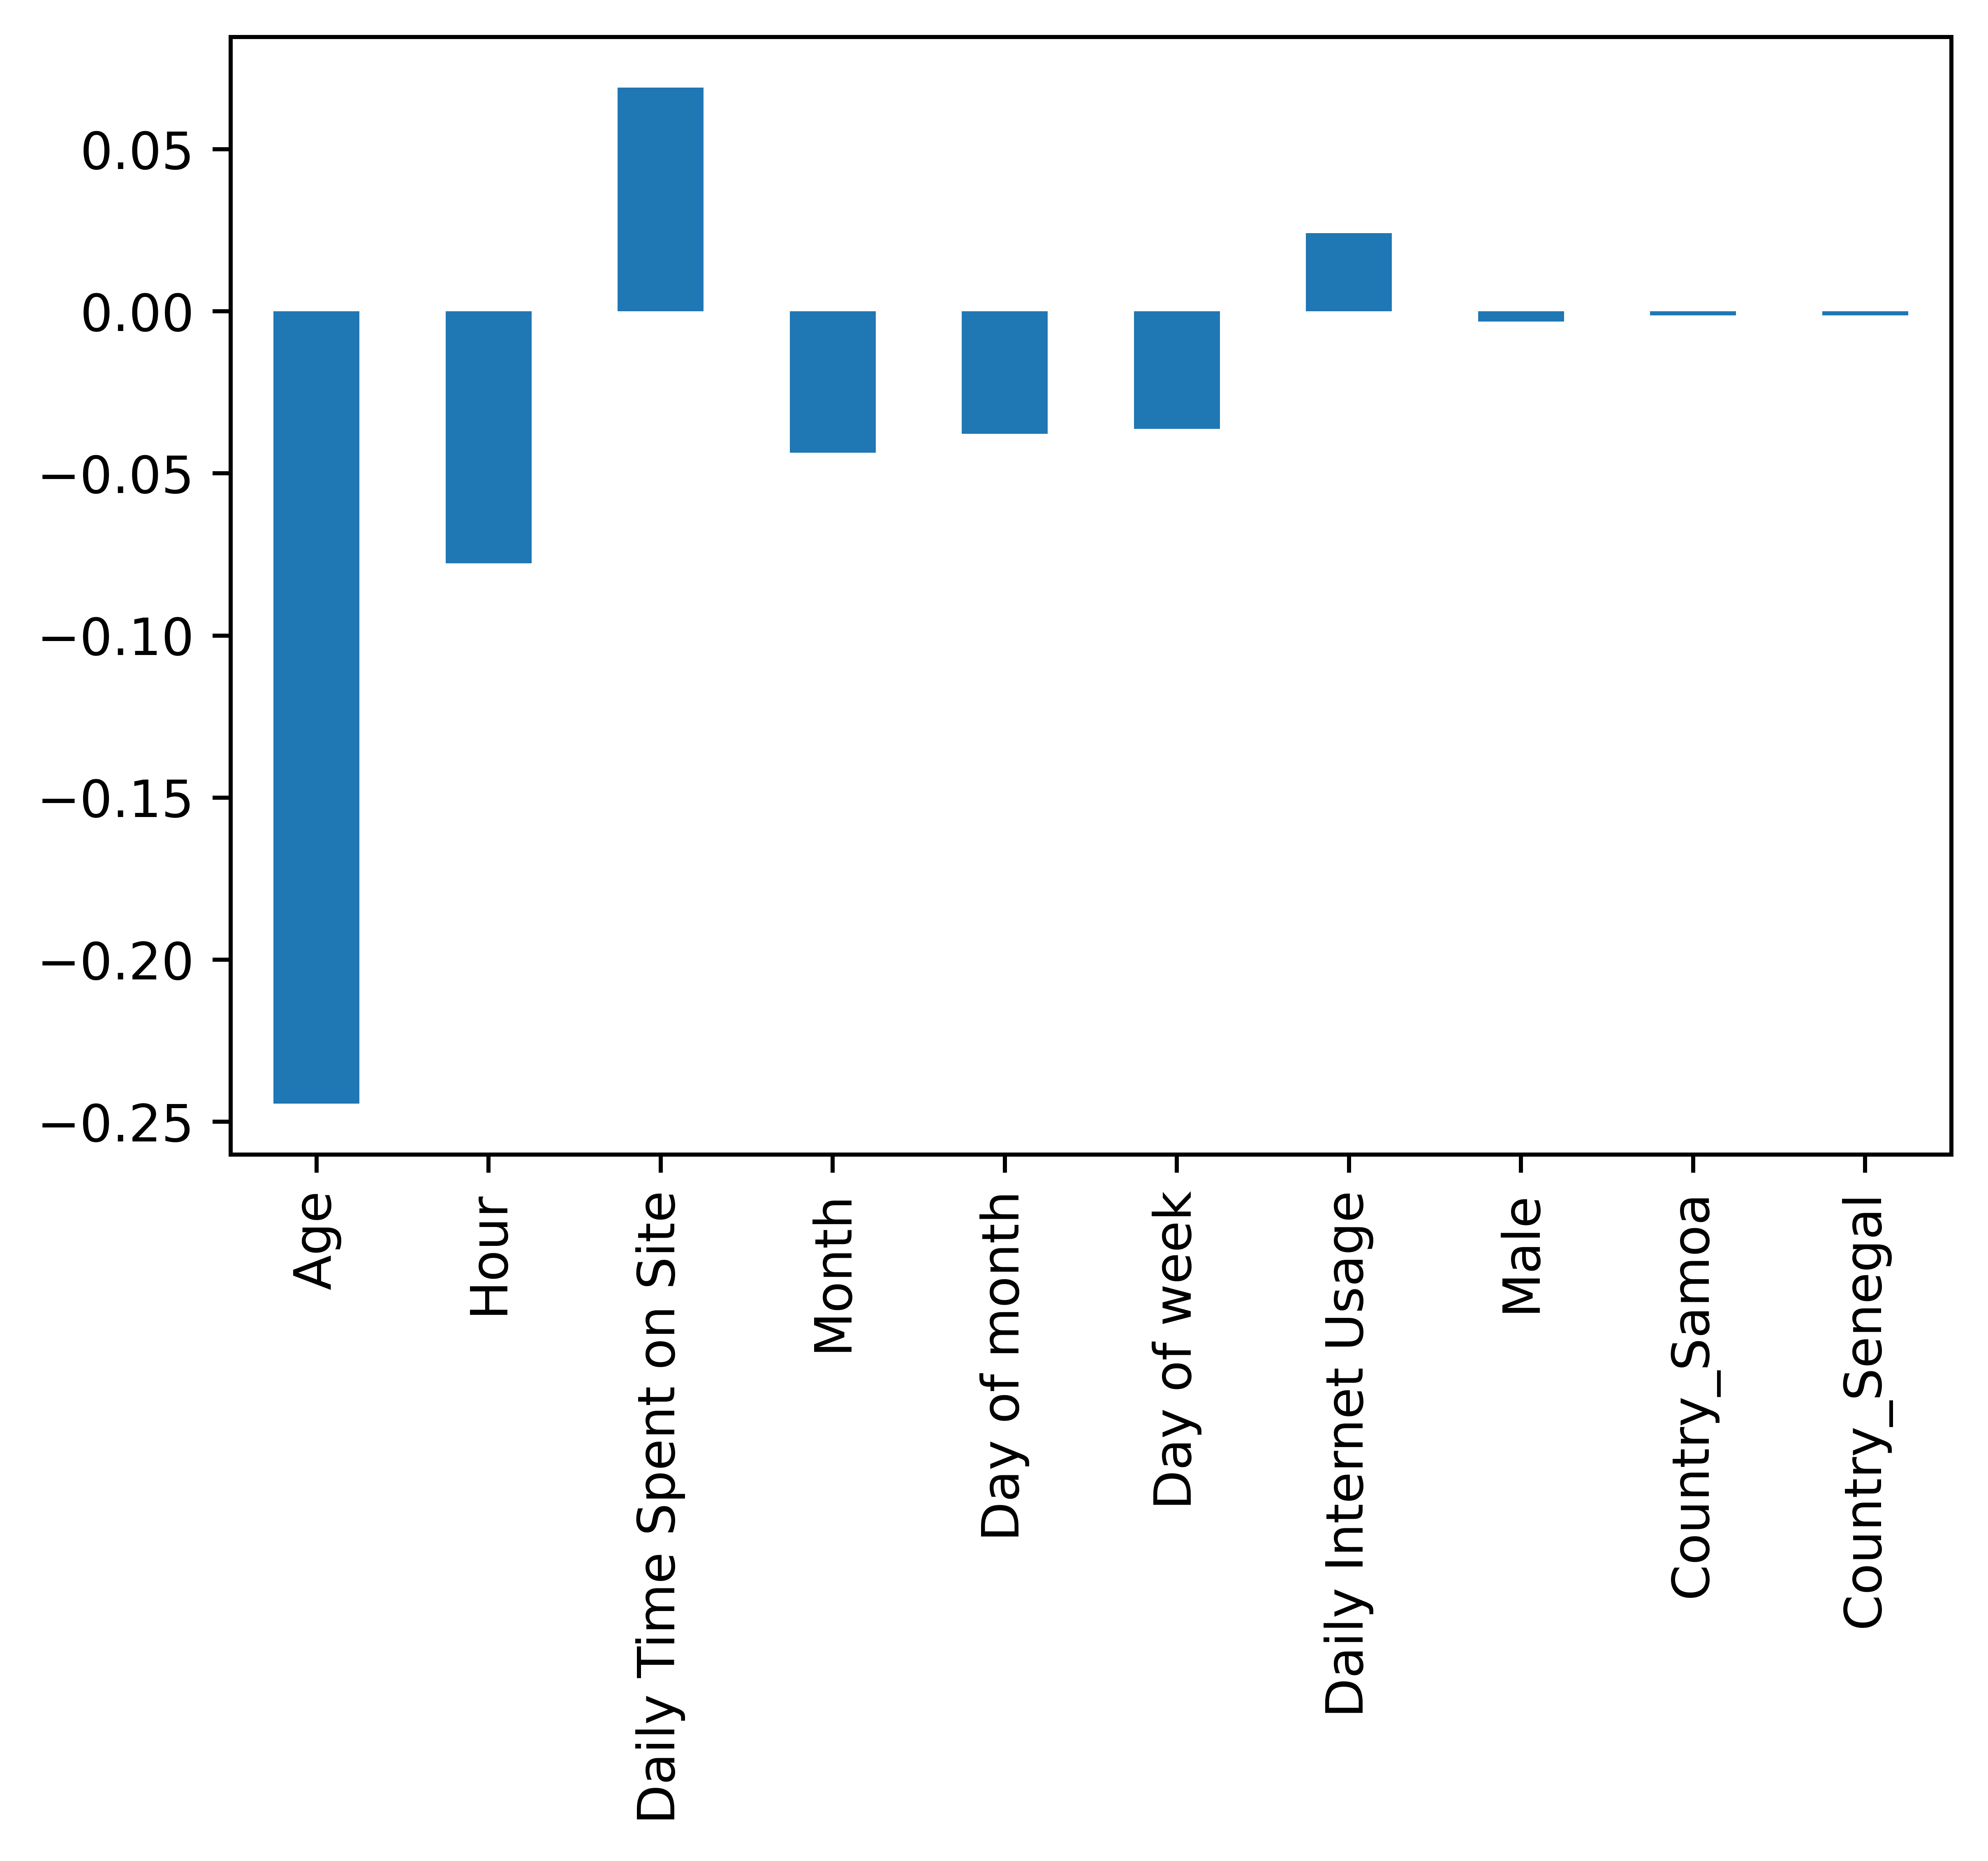

In [32]:
factors = model.get_covariate_importance()
n_factors = len(factors)
risk_factors = pd.Series({encoded_data.columns[i]: factors[i] for i in range(n_factors)})
top_ten_factors_in_absvalue = risk_factors.abs().sort_values(ascending=False)[0:10]
risk_factors.filter(top_ten_factors_in_absvalue.index).plot.bar()

## Visualizing the cured/not cured distribution in the test set
We assume that points where the probability of cure outcome is >0.5 are all cured. All points under that threshold are considered not cured. 

In [33]:
outcome_probas = model.predict_cure_proba(test_data, test_labels)[:,0]
cured_probas = outcome_probas[outcome_probas>0.5]
notcured_probas = outcome_probas[outcome_probas<=0.5]

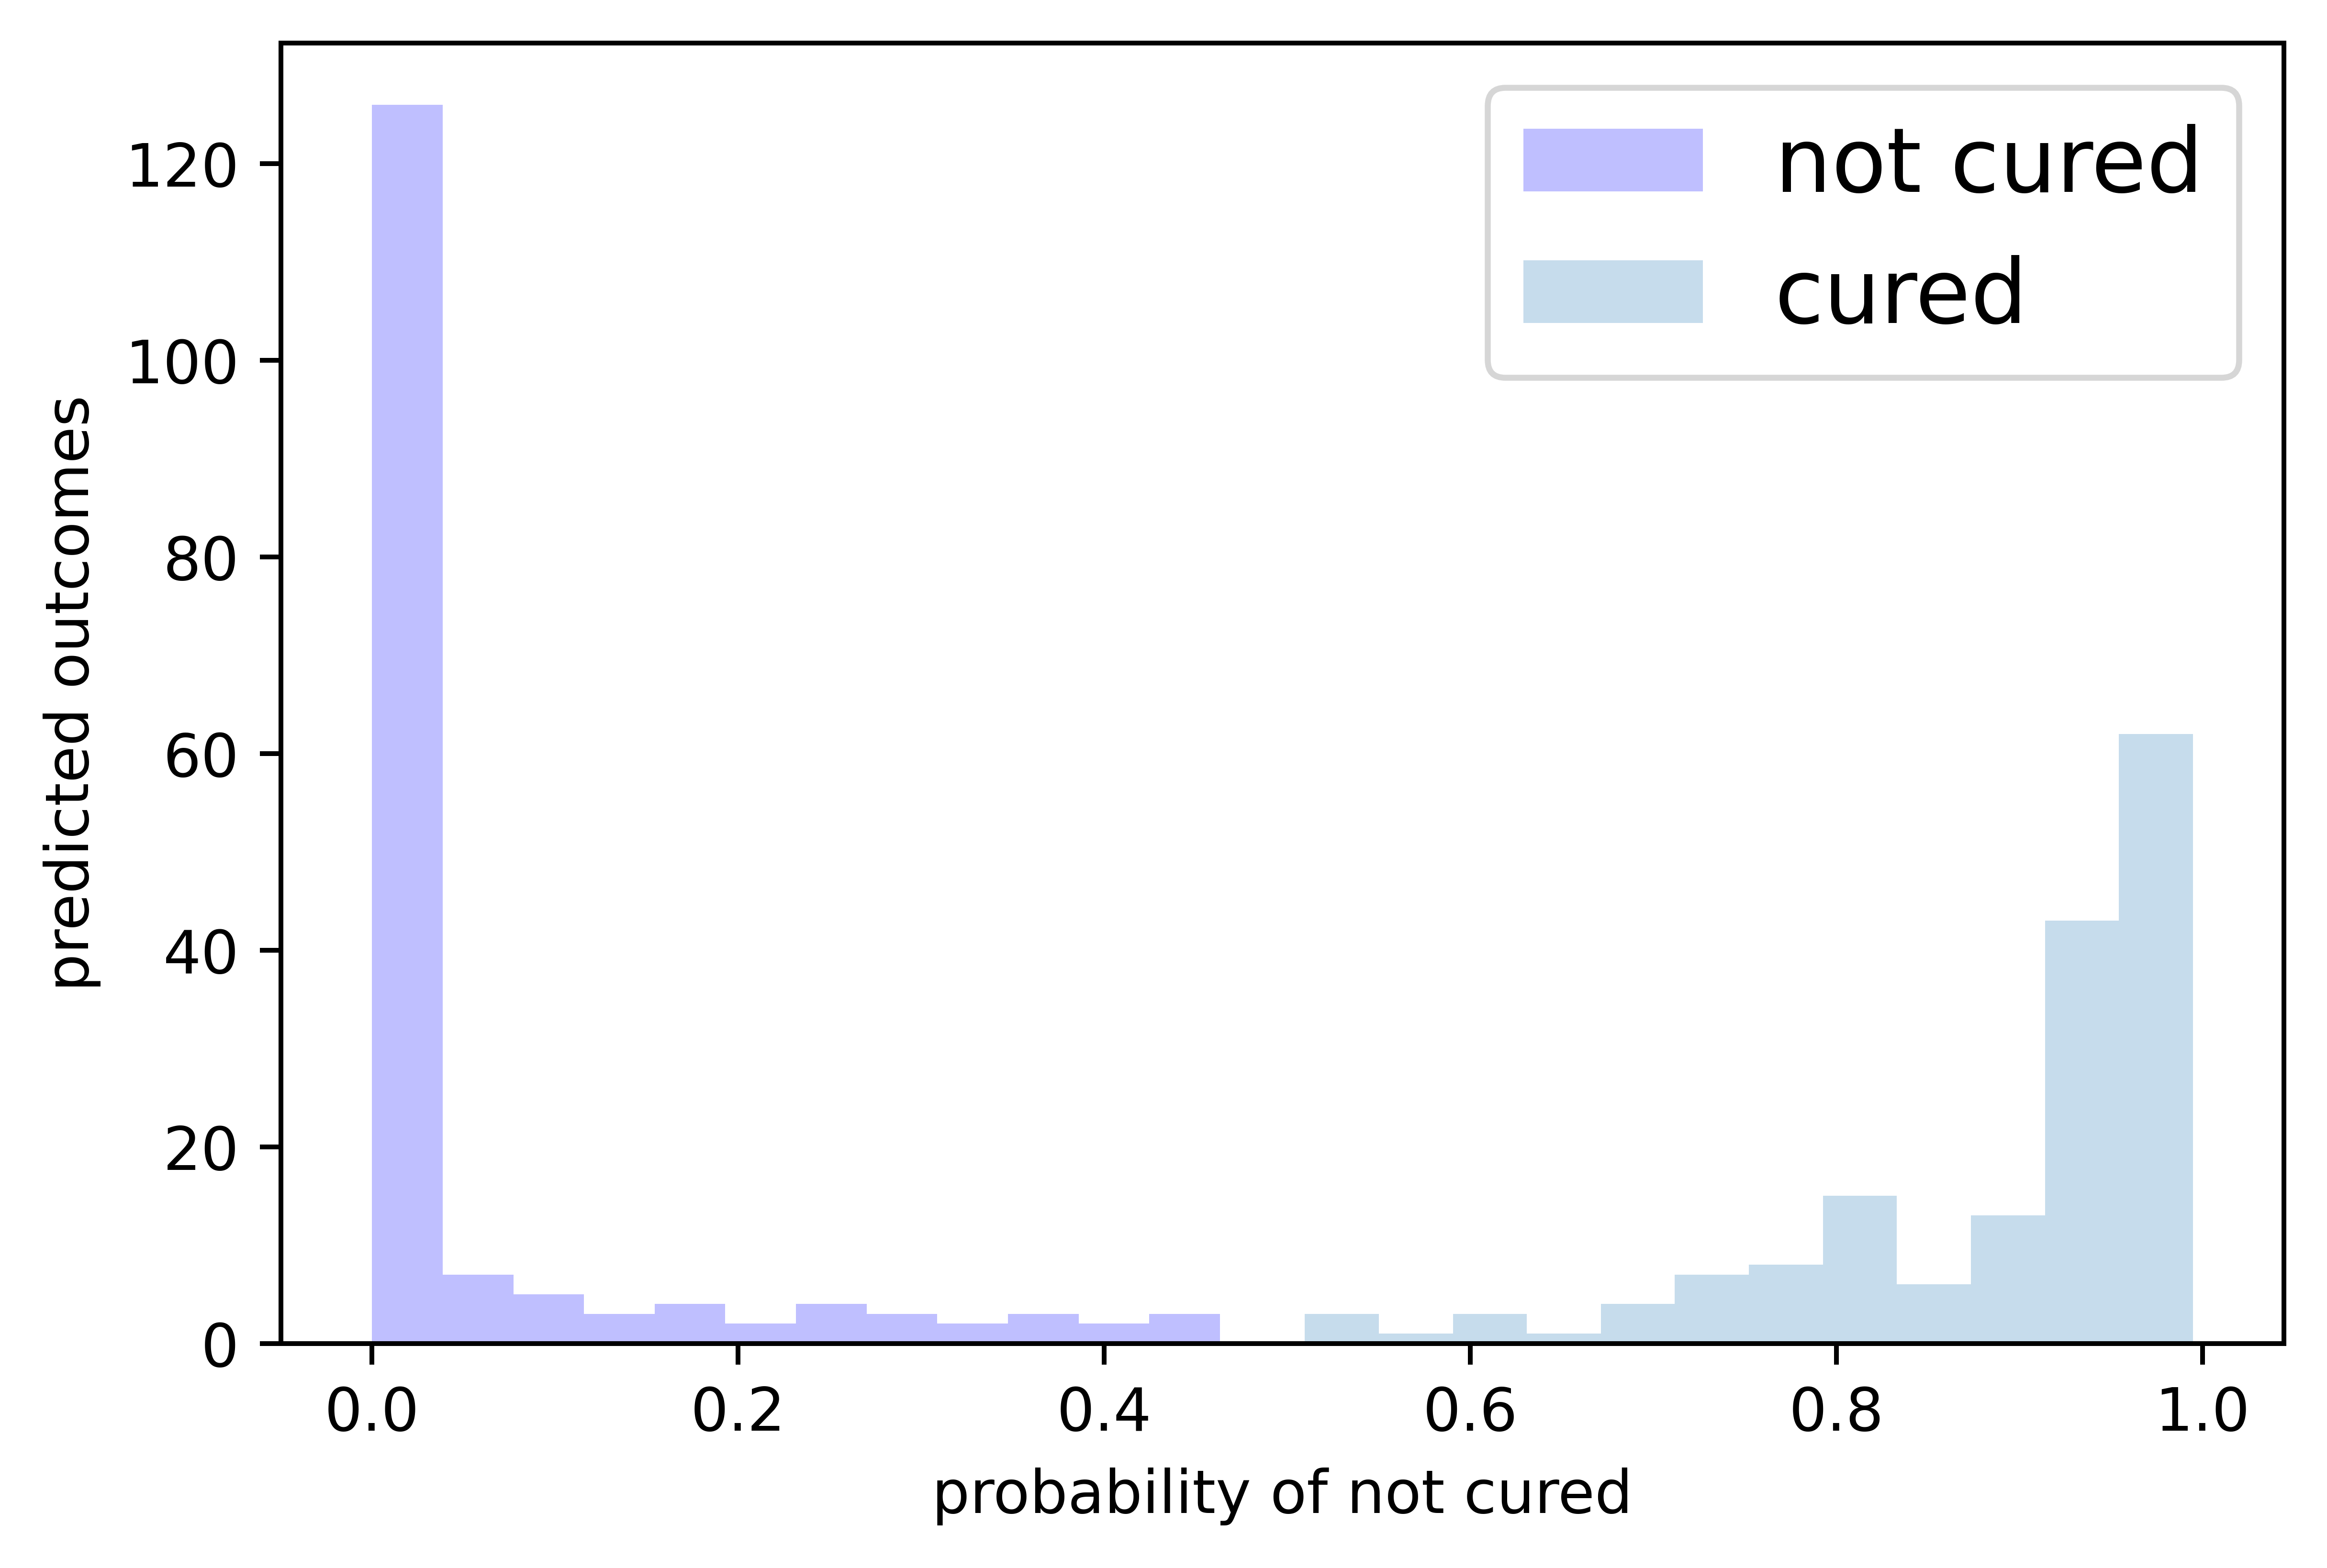

In [34]:
# We plot the predicted cured (not cured) labels on y-axis and 
# the probability of not being cured on the x-axis.
plt.xlabel('probability of not cured')
plt.ylabel('predicted outcomes')
plt.hist(notcured_probas, bins=12, label='not cured', color='blue', alpha=0.25)
plt.hist(cured_probas, bins=12, label='cured', alpha=0.25)
plt.legend(fontsize=15)
plt.show()